### Plots for logit based

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import roc_auc_score
import seaborn as sns

import numpy as np

df_results = pd.read_csv("./processed_csvs/classification.csv")


def convert_to_float_list(string_list):
    return [float(x) for x in string_list.strip("[]").split(", ")]


# Apply the function to the 'probabilities' column
df_results["probabilities"] = df_results["probabilities"].apply(convert_to_float_list)
df_results["positive_probabilities"] = [p[1] for p in df_results["probabilities"]]
all_datasets = df_results["dataset"].unique()
all_models = df_results["model"].unique()
all_annotators = df_results["annotator"].unique()
df_results = df_results.sort_values(by=["dataset", "model", "annotator"])
all_auroc = []

df_list = []

for dataset in all_datasets:
    for model in all_models:
        for annotator in all_annotators:
            df = df_results[
                (df_results["dataset"] == dataset)
                & (df_results["model"] == model)
                & (df_results["annotator"] == annotator)
            ].copy()
            labels = df["gold_class"].unique()
            auroc = roc_auc_score(df["gold_class"], df["positive_probabilities"])
            df["auroc"] = auroc
            df_list.append(df)

df_results = pd.concat(df_list)
df_results = df_results.drop(["instance", "probabilities"], axis=1)

df_results_grouped = (
    df_results.groupby(["task_type", "dataset", "model", "annotator"])
    .mean()
    .reset_index()
)

In [2]:
def get_results_stacked(df_results_grouped, how="max"):
    datasets = df_results_grouped["dataset"].unique()
    models = df_results_grouped["model"].unique()
    if how == "max":
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "auroc"]]
            .groupby(["dataset", "model"])
            .max()
            .reset_index()
        )
    elif how == "min":
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "auroc"]]
            .groupby(["dataset", "model"])
            .min()
            .reset_index()
        )
    else:
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "auroc"]]
            .groupby(["dataset", "model"])
            .mean()
            .reset_index()
        )

    df_results_grouped_max = (
        df_results_grouped_max[["model", "auroc"]].groupby("model").mean()
    )

    return df_results_grouped_max

In [3]:
df_results_grouped = df_results_grouped[["dataset", "model", "annotator", "auroc"]]

annotators = df_results_grouped["annotator"].unique()
datasets = df_results_grouped["dataset"].unique()
models = df_results_grouped["model"].unique()

# for each model,dataset pair, get the annotator with the highest f1

In [4]:
df_results_grouped_max_cnt = get_results_stacked(df_results_grouped, "max")
df_results_grouped_min_cnt = get_results_stacked(df_results_grouped, "min")
df_results_grouped_mean_cnt = get_results_stacked(df_results_grouped, "mean")
df_results_grouped_max_cnt["type"] = "Best"
df_results_grouped_min_cnt["type"] = "Worst"
df_results_grouped_mean_cnt["type"] = "Median"

# stack

results = pd.concat(
    [
        df_results_grouped_max_cnt,
        df_results_grouped_mean_cnt,
        df_results_grouped_min_cnt,
    ]
)


ORDER_MAP = {
    "Llama-2-7b-chat-hf": 2,
    "Llama-2-13b-chat": 1,
    "alpaca-7b": 3,
    "mistral-7b": 0,
    "asclepius": 6,
    "clinical-camel-7b": 5,
    "medalpaca-7b": 7,
}

results["order"] = results.index.map(ORDER_MAP)
results = results.sort_values(by=["order", "type"])

In [5]:
MODEL_MAP = {
    "mistral-7b": "Mistral (7b)",
    "Llama-2-7b-chat-hf": "Llama-2 (7b)",
    "asclepius": "Asclepius (7b)",
    "Llama-2-13b-chat": "Llama-2 (13b)",
    "clinical-camel-7b": "Clin-Camel (13b)",
    "alpaca-7b": "Alpaca (7b)",
    "medalpaca-7b": "MedAlpaca (7b)",
}
models_a = ["Mistral (7b)", "Llama-2 (7b)", "Llama-2 (13b)", "Alpaca (7b)"]
models_b = ["Asclepius (7b)", "Clin-Camel (13b)", "MedAlpaca (7b)"]
results = results.reset_index()

results["model"] = results.model.map(MODEL_MAP)
results.columns = ["Model", "AUROC", "Prompt", "order"]

/tmp/ipykernel_68878/2888371410.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)


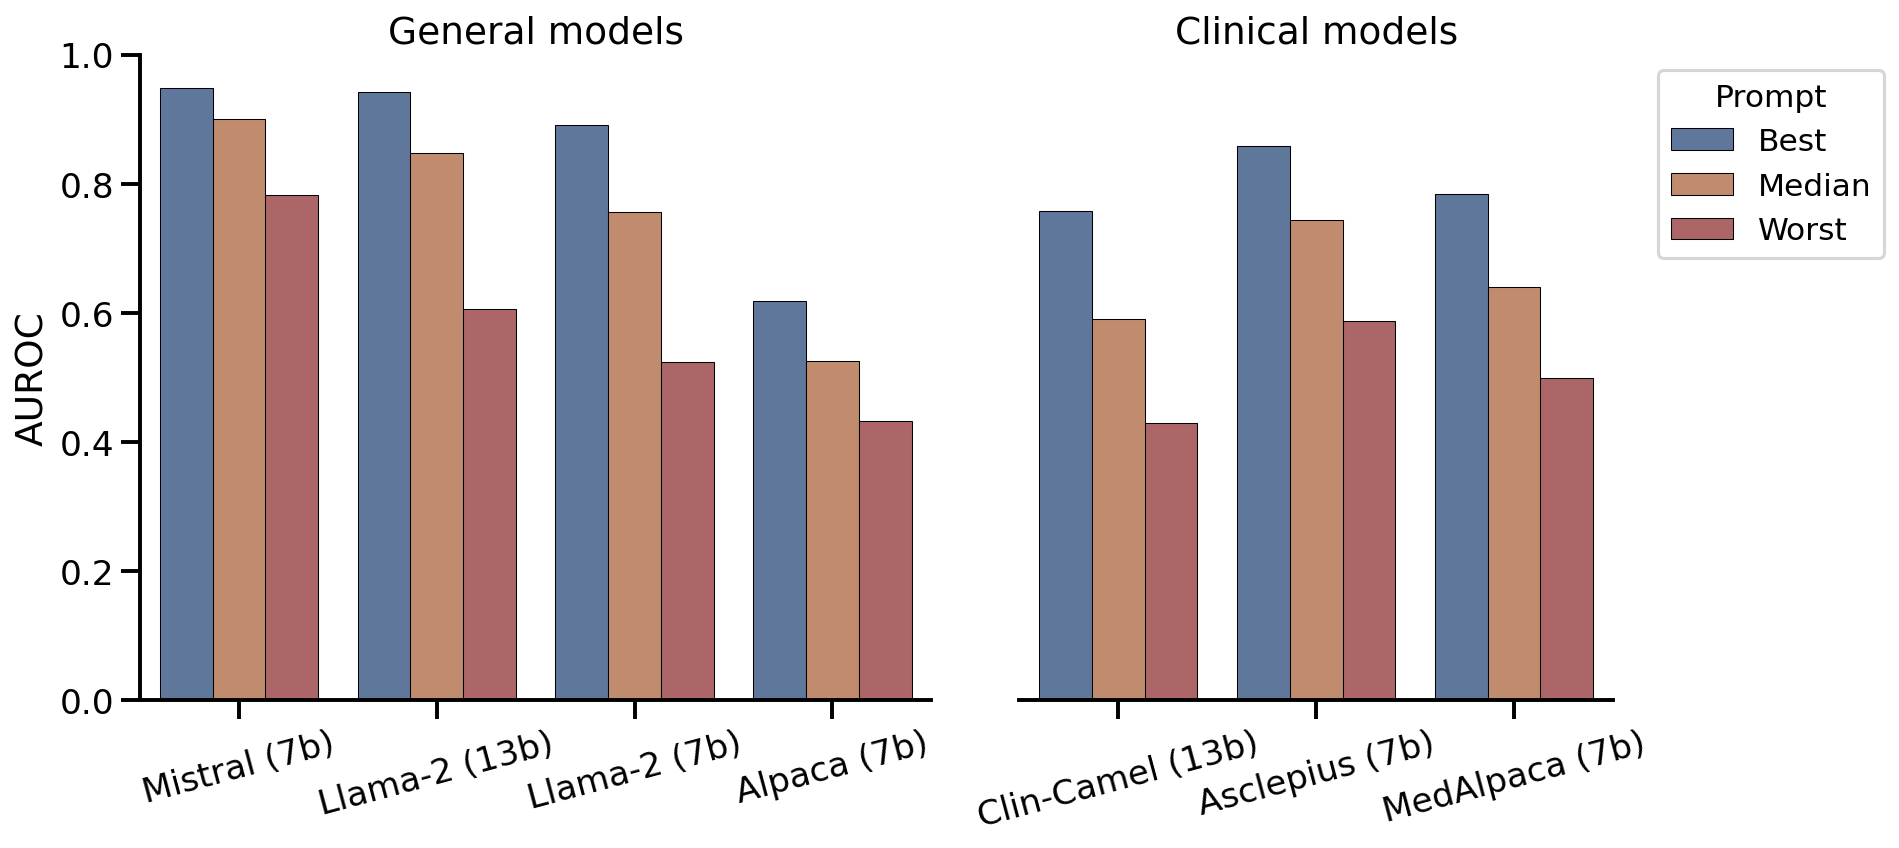

In [6]:
# fig = plt.figure(dpi=100)
colors = sns.color_palette("deep", 10, desat=0.8)
COLOR_MAP = {
    "Best": colors[0],
    "Median": colors[1],
    "Worst": colors[3],
}
sns.set_context("talk")
fig, ax = plt.subplots(
    1,
    2,
    dpi=150,
    figsize=(13, 6),
    gridspec_kw={"width_ratios": [4, 3]},
    sharey=True,
)
# add borders to bars

# set lower title for full figure
# fig.suptitle("Model", y=0.05)

ax1 = ax[0]
results_a = results[results["Model"].isin(models_a)]
g = sns.barplot(
    ax=ax1,
    data=results_a,
    x="Model",
    y="AUROC",
    hue="Prompt",
    # kind="bar",
    palette=COLOR_MAP,
    # height=5,
    # aspect=2,
    edgecolor="black",
    linewidth=0.5,
)

ax1.set_title("General models")
ax1.set_ylim(0, 1)
# remove legend for ax1
ax1.get_legend().remove()
# rotate y axis
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)


results_b = results[results["Model"].isin(models_b)]
ax2 = ax[1]
# make all bars the same width
g = sns.barplot(
    ax=ax2,
    data=results_b,
    x="Model",
    y="AUROC",
    hue="Prompt",
    # kind="bar",
    palette=COLOR_MAP,
    # height=5,
    # aspect=2,
    edgecolor="black",
    linewidth=0.5,
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title("Clinical models")

# remove x label
ax2.set_xlabel("")
ax1.set_xlabel("")
# rotate y axis
plt.xticks(rotation=15)
# despine
sns.despine()
# remove y spine in ax2 and ticks
ax2.spines["left"].set_visible(False)
ax2.yaxis.set_visible(False)
# put legend outside of the figure
plt.legend(
    title="Prompt",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small",
    title_fontsize="small",
)
plt.tight_layout()

plt.savefig("rankings_cls.pdf", bbox_inches="tight")

# EXTRACTION

In [21]:
def get_results_stacked(df_results_grouped, how="max"):
    datasets = df_results_grouped["dataset"].unique()
    models = df_results_grouped["model"].unique()
    if how == "max":
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "F1"]]
            .groupby(["dataset", "model"])
            .max()
            .reset_index()
        )
    elif how == "min":
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "F1"]]
            .groupby(["dataset", "model"])
            .min()
            .reset_index()
        )
    else:
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "F1"]]
            .groupby(["dataset", "model"])
            .mean()
            .reset_index()
        )

    df_results_grouped_max = (
        df_results_grouped_max[["model", "F1"]].groupby("model").mean()
    )

    return df_results_grouped_max

In [23]:
columns = ["dataset", "model", "annotator", "F1"]

df_results_grouped_extraction = pd.read_csv("./processed_csvs/extraction_grouped.csv")
df_results_grouped_extraction = df_results_grouped_extraction.rename(
    columns={"f1_score": "F1"}
).reset_index()

df_results_grouped_max_cnt = get_results_stacked(df_results_grouped_extraction, "max")
df_results_grouped_min_cnt = get_results_stacked(df_results_grouped_extraction, "min")
df_results_grouped_mean_cnt = get_results_stacked(df_results_grouped_extraction, "mean")
df_results_grouped_max_cnt["type"] = "Best"
df_results_grouped_min_cnt["type"] = "Worst"
df_results_grouped_mean_cnt["type"] = "Median"
results = [
    df_results_grouped_max_cnt,
    df_results_grouped_mean_cnt,
    df_results_grouped_min_cnt,
]
results = pd.concat(results)
results

,F1,type
model,,
Llama-2-13b-chat,0.380826,Best
Llama-2-7b-chat-hf,0.399498,Best
alpaca-7b,0.211708,Best
asclepius,0.319274,Best
clinical-camel-7b,0.386140,Best
medalpaca-7b,0.305229,Best
mistral-7b,0.323974,Best
Llama-2-13b-chat,0.281370,Median
Llama-2-7b-chat-hf,0.323789,Median


In [24]:
results["order"] = results.index.map(ORDER_MAP)
results = results.sort_values(by=["order", "type"])
MODEL_MAP = {
    "Llama-2-7b-chat-hf": "Llama-2 (7b)",
    "asclepius": "Asclepius (7b)",
    "Llama-2-13b-chat": "Llama-2 (13b)",
    "clinical-camel-7b": "Clin-Camel (13b)",
    "alpaca-7b": "Alpaca (7b)",
    "medalpaca-7b": "MedAlpaca (7b)",
    "mistral-7b": "Mistral (7b)",
}
models_a = ["Mistral (7b)", "Llama-2 (7b)", "Llama-2 (13b)", "Alpaca (7b)"]
models_b = ["Asclepius (7b)", "Clin-Camel (13b)", "MedAlpaca (7b)"]
results = results.reset_index()

results["model"] = results.model.map(MODEL_MAP)
results.columns = ["Model", "F1", "Prompt", "order"]

/tmp/ipykernel_68878/1244515320.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)


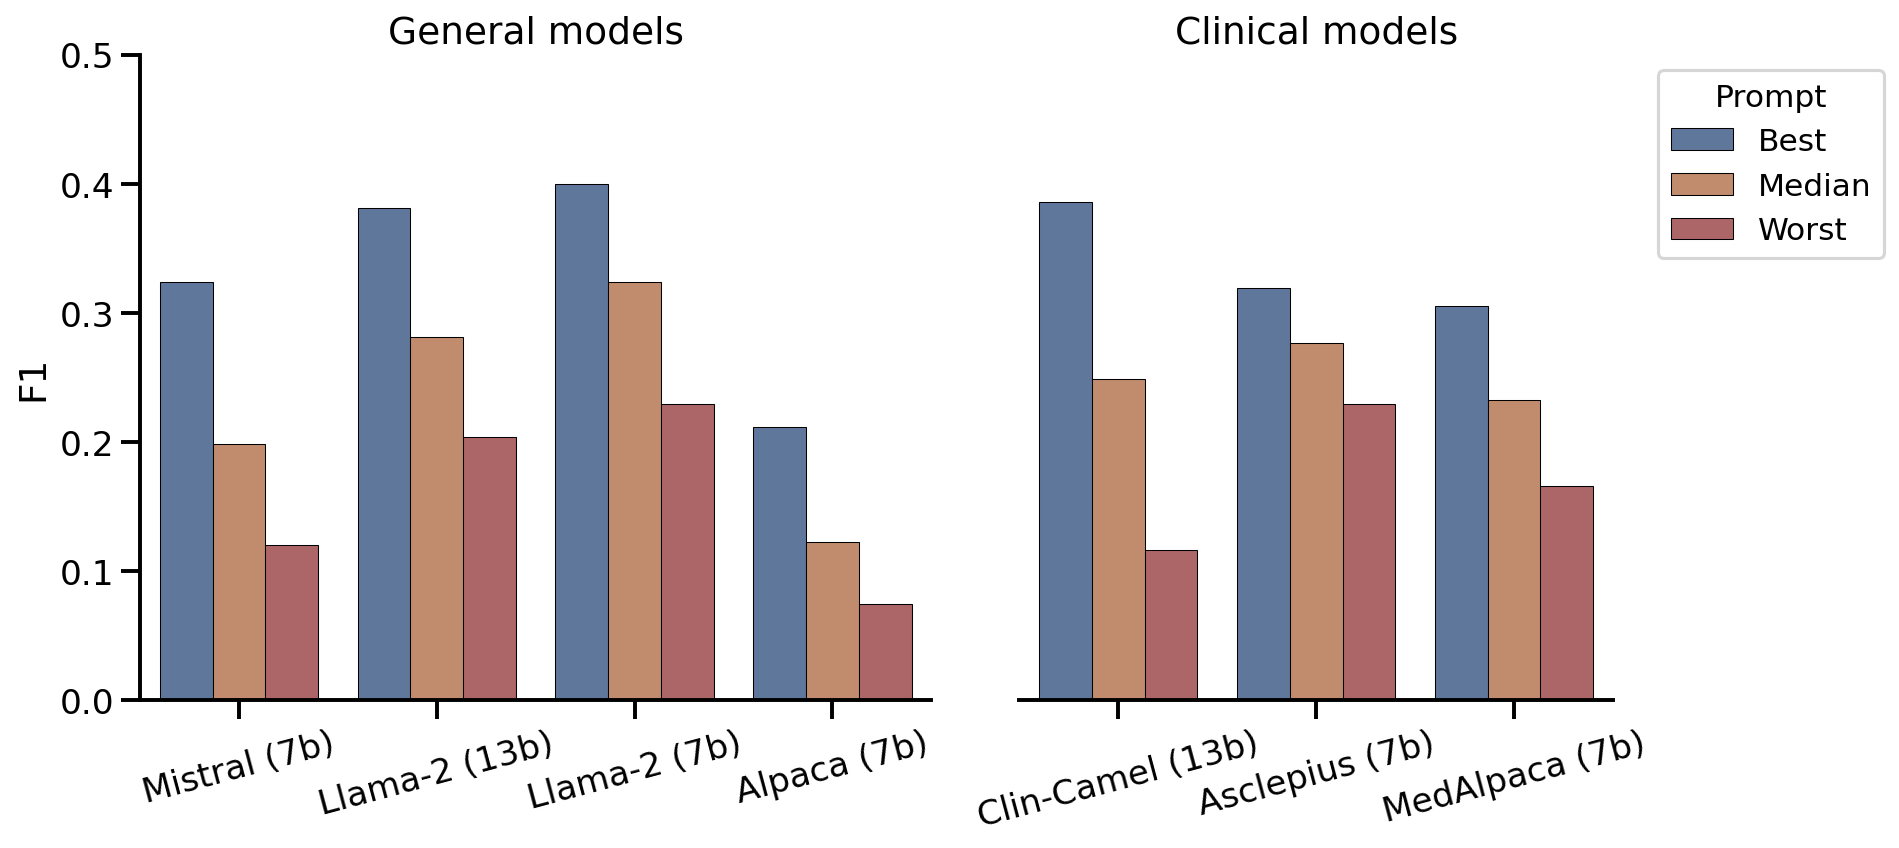

In [25]:
# fig = plt.figure(dpi=100)
sns.set_context("talk")
fig, ax = plt.subplots(
    1,
    2,
    dpi=150,
    figsize=(13, 6),
    gridspec_kw={"width_ratios": [4, 3]},
    sharey=True,
)
# add borders to bars

# set lower title for full figure
# fig.suptitle("Model", y=0.05)

ax1 = ax[0]
results_a = results[results["Model"].isin(models_a)]
g = sns.barplot(
    ax=ax1,
    data=results_a,
    x="Model",
    y="F1",
    hue="Prompt",
    # kind="bar",
    palette=COLOR_MAP,
    # height=5,
    # aspect=2,
    edgecolor="black",
    linewidth=0.5,
)

ax1.set_title("General models")
ax1.set_ylim(0, 1)
# remove legend for ax1
ax1.get_legend().remove()
# rotate y axis
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)


results_b = results[results["Model"].isin(models_b)]
ax2 = ax[1]
# make all bars the same width
g = sns.barplot(
    ax=ax2,
    data=results_b,
    x="Model",
    y="F1",
    hue="Prompt",
    # kind="bar",
    palette=COLOR_MAP,
    # height=5,
    # aspect=2,
    edgecolor="black",
    linewidth=0.5,
)

ax1.set_ylim(0, 0.5)
ax2.set_ylim(0, 0.5)
ax2.set_title("Clinical models")

# remove x label
ax2.set_xlabel("")
ax1.set_xlabel("")
# rotate y axis
plt.xticks(rotation=15)
# despine
sns.despine()
# remove y spine in ax2 and ticks
ax2.spines["left"].set_visible(False)
ax2.yaxis.set_visible(False)
# put legend outside of the figure
plt.legend(
    title="Prompt",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small",
    title_fontsize="small",
)
plt.tight_layout()

plt.savefig("ranking_ext.pdf", bbox_inches="tight")